# **Import Libraries and set environment**
First step is importing all required libraries for the proyect.

In [ ]:
# Read and process csv files.
import pandas as pd
# Treat numbers.
import numpy as np
# Deal with directories and files.
import glob
# Creating and deleting directories
import os
import shutil
# Measure execution times.
import time
# Randomize arrays
from random import shuffle
# Plot charts and graphics.
import matplotlib.pyplot as plt
# sklearn for cross-validation.
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Statistics over lists.
import statistics 
# Keras for machine learning.
import keras
from keras import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers import LSTM, Dense, Dropout, Input, Activation, Masking, Conv1D, Flatten

The following cell removes the output directory and it content, and creates it again empty.

In [ ]:
# Create empty content.   
if not os.path.exists('/content'):
    os.makedirs('/content')


# Return to content dir.
os.chdir('/content')

# Delete out and content.
try:
    shutil.rmtree("out/")
except OSError as e:
    print("Error: The directory do not exist.")

# Create empty out.   
if not os.path.exists('out'):
    os.makedirs('out')

# Change dir to out.
os.chdir('out')

print(os.getcwd())

/content/out


# **Parameters**
All the parameters used in the project has been collected here.

In [ ]:
#@markdown Path and extension of dataset files.
dataset_path = "drive/MyDrive/Datasets/KSAS-1/*.csv" #@param {type:"string"}

#@markdown Left-right differences or not
left_right = True #@param {type:"boolean"}
arm = "d" #@param {type:"string"}
#@markdown Apply or not EWMA to smooth curves.
ewma = True #@param {type:"boolean"}

#@markdown Value of beta in EWMA.
ewma_b = 0.3 #@param {type:"number"}

#@markdown Apply or not normalization to set data in range .
norm = False #@param {type:"boolean"}

#@markdown Columns to drop. Options: ["accelerometer_x", "accelerometer_y", "accelerometer_z", "gyros_x", "gyros_y", "gyros_z", "magn_field_x", "magn_field_y", "magn_field_z", "game_rot_vec_x", "game_rot_vec_y", "game_rot_vec_z", "gravity_x", "gravity_y", "gravity_z", "lin_accel_x", "lin_accel_y", "lin_accel_z"]
drop = [] #@param {type:"raw"}


#@markdown Which normalization method use: [std_mean, min_max]
chosen_norm = "min_max" #@param ["std_mean", "min_max"]

#@markdown Which model train. Options: [ann, rnn, cnn]
chosen_model = "ann" #@param ["ann", "rnn", "cnn"]

#@markdown Number of folds
num_folds =  4 #@param {type:"integer"}

#@markdown Stratified kFolds.
stratified = True #@param {type:"boolean"}

#@markdown learning rate
adam_learning_rate = 0.0005 #@param {type:"number"}

#@markdown Parameters of Adam optimizer:
adam_beta_1 = 0.9 #@param {type:"number"}
adam_beta_2 = 0.999 #@param {type:"number"}
adam_decay = 0.0001 #@param {type:"number"}

#@markdown Model fit parameters:
model_loss = 'logcosh' #@param ["logcosh", "MeanSquaredError", "MeanAbsoluteError", "MeanAbsolutePercentageError", "MeanSquaredLogarithmicError", "CosineSimilarity", "Huber"]
model_validation_split = 0.2 #@param {type:"number"}
model_test_split = 0.2 #@param {type:"number"}
model_batch_size = 40 #@param {type:"integer"}
model_epochs = 2000 #@param {type:"integer"}

#@markdown Output directory:
output_dir = 'out/' #@param {type:"string"}

#@markdown Batch training
batch_training = True #@param {type:"boolean"}
batch_learning_rate = [0.00005] #@param {type:"raw"}
batch_chosen_model = ['ann', 'cnn', 'rnn'] #@param {type:"raw"}
batch_ewma_b = np.logspace(1, 3, 5, endpoint = True)/1000 #@param {type:"raw"}


# **Load dataset**
The dataset is loaded here. It consist in a set of csv files, each one containing a movement of the execution of one participant. The name of the csv files follows the format a-b-c.csv, where:
*   **a**: number of movement.
*   **b**: id of participant.
*   **c**: 'i' or 'd' indicating if the execution has been made with the left or right arm respectively.

All the movements must be located in a folder named 'movements'.



In [ ]:
# Load files of dataset.
files = glob.glob("../" + dataset_path)
print(files)

# List for storing elements of the dataset.
X_raw = []
Y_raw = []

# Read files and store each example in list.
for path in files:
    df = pd.read_csv(path, sep=",", decimal=".", header=0)
    df = df.apply(pd.to_numeric)
    df = df.drop(drop, axis=1)
    

    if left_right:
      if path.split("/")[5].split(".")[0].split("-")[2] == arm:
        # Convert df into list.
        X_raw.append(df.T.values.tolist())
        # Get class (movement) from file name.
        Y_raw.append(path.split("/")[5][0])
    else:
      # Convert df into list.
      X_raw.append(df.T.values.tolist())
      # Get class (movement) from file name.
      Y_raw.append(path.split("/")[5][0])

['../drive/MyDrive/Datasets/KSAS-1/2-14-d.csv', '../drive/MyDrive/Datasets/KSAS-1/3-14-d.csv', '../drive/MyDrive/Datasets/KSAS-1/4-14-d.csv', '../drive/MyDrive/Datasets/KSAS-1/5-14-d.csv', '../drive/MyDrive/Datasets/KSAS-1/1-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/2-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/3-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/4-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/5-14-i.csv', '../drive/MyDrive/Datasets/KSAS-1/1-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/2-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/3-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/4-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/5-20-d.csv', '../drive/MyDrive/Datasets/KSAS-1/1-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/3-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/4-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/5-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/2-20-i.csv', '../drive/MyDrive/Datasets/KSAS-1/3-19-d.csv', '../drive/MyDrive/Datasets/KSAS-1/4-19-d.csv', '../drive/My

After loading the dataset, we obtain two lists: X_raw and Y_raw. X_raw contains the signals measured for a movement, and Y_raw contains the class to which each element of X_raw belongs.

Let's print one of the movements and its class.

In [ ]:
print(X_raw[1][2])
print(Y_raw)
np.savetxt("raw.csv", X_raw[1][2], delimiter=",")

[-23.195, -21.491999999999997, -20.298, -15.397, -12.368, -10.01, -7.452999999999999, -7.053, -7.4270000000000005, -6.481, -5.959, -6.928999999999999, -8.037, -8.506, -9.962, -11.745999999999999, -13.437999999999999, -14.686, -16.362000000000002, -18.639, -19.673, -21.03, -26.448, -34.055, -35.637, -35.951, -35.094, -31.524, -31.057, -25.590999999999998, -17.801, -11.274000000000001, 1.5490000000000002, 4.7410000000000005, 8.655]
['2', '3', '4', '5', '1', '2', '3', '4', '5', '3', '4', '5', '1', '2', '2', '1', '5', '4', '3', '2', '1', '5', '4', '3', '1', '5', '4', '3', '2', '2', '1', '3', '4', '5', '1', '4', '3', '5', '2', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '1', '2', '3', '4', '5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

# **Normalization**

As a way to speed up learnig, we are going to normalize the dataset. This will make each attribute to have a mean closer to 0. The normalization is done by attribute and not globally.

In [ ]:
if(norm):
  X_norm = []
  for example in X_raw:
    resExample = []
    for attribute in example:
      if chosen_norm == "std_mean":
        resExample.append((attribute - np.mean(example)) / np.std(attribute))
      elif chosen_norm == "min_max":
        resExample.append((attribute - np.min(example)) / (np.max(example) - np.min(example)))
    X_norm.append(resExample.copy())
else:
  X_norm = X_raw

Now we have the dataset normalized.

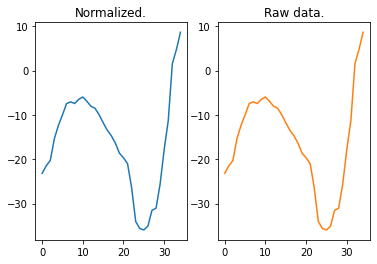

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(X_norm[1][2], 'tab:blue')
ax1.set_title("Normalized.")
ax2.plot(X_raw[1][2], 'tab:orange')
ax2.set_title("Raw data.")
plt.show()
# np.savetxt("norm.csv", X_norm[1][2], delimiter=",")

# **Smooth the curves**
The curves genedated by the attributes in each sample are so sharp and noisy. We can smooth this curves using Exponentially Weighted Moving Averages. Let's define a function to smooth this curves.

In [ ]:
def applyEWMA(beta, dataset):
    pos = 0
    resX = []
    for example in dataset:
        resExample = []
        for attribute in example:
            resAttribute = [attribute[0]]
            for value in attribute:
                resValue = (beta * value) + (1-beta) * resAttribute[pos]
                resAttribute.append(resValue)
                pos += 1
            resAttribute.pop(0)
            resExample.append(resAttribute.copy())
            resAttribute.clear()
            pos = 0
        resX.append(resExample.copy())
        resExample.clear()
    return resX

Now, we can use this function to apply EWMA over the full dataset.

In [ ]:
if(ewma):
    X_smooth = applyEWMA(ewma_b, X_norm)

Let's take a look of how we have smoothen our curves.

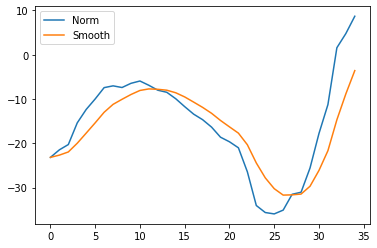

In [ ]:
if(ewma):
  plt.plot(X_norm[1][2], label='Norm')
  plt.plot(X_smooth[1][2], label='Smooth')
  plt.legend()
  plt.show()
  np.savetxt("smooth2.csv", X_smooth[1][2], delimiter=",")

By adjusting the value of beta, we can control how smooth the new curves are. Lower values of beta gives smoother curves. If beta is 1, the generated curve is the same as the original.

# **Padding the sequences**
For feeding the neural networks, all sequences must have the same length. Here, the length of the longest sequence is obtained, so all the sequences can be expanded (padded) till reach the length of the longest sequence in the dataset.

In [ ]:
maxLength = 0
for example in X_smooth:
  if len(example[0]) > maxLength:
    maxLength = len(example[0])
print("Length of longest sample: " + str(maxLength))

Length of longest sample: 54


Now, we are going to expand each sample.

In [ ]:
# Extend each sample to maximum length
X_expanded = []
for example in X_smooth:
  resExample = pad_sequences(example, padding='post', maxlen=maxLength, dtype='float64')
  X_expanded.append(resExample)

Let's see an example of expanded movement.

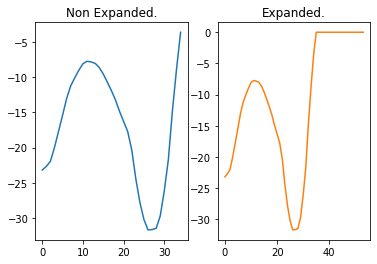

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(X_smooth[1][2], 'tab:blue')
ax1.set_title("Non Expanded.")
ax2.plot(X_expanded[1][2], 'tab:orange')
ax2.set_title("Expanded.")
plt.show()
# np.savetxt("pad.csv", X_expanded[1][2], delimiter=",")

# **Convert to ndarray**

Right now, we have a list of examples, where each one is a ndarray containing 18 attributes. Each attribute has the length of the previously calculated max length. We should turn that list in an ndarray, resulting in a 3-dimensional ndarray. The output Y should be formed by one-hot vectors, so we will use the function to_categorical to turn each output in a one-hot vector.

In [ ]:
# Convert into Array
X = np.asarray(X_expanded)
print(X.shape)
Y = np.asarray(Y_raw)
print(Y.shape)
Y = to_categorical(Y)
print(Y.shape)

(120, 18, 54)
(120,)
(120, 6)


As input dataset for trainig, we are going to use the smoothen and normalized dataset X_norm. Let's get its dimensions.

In [ ]:
# Get dimensions
num_examples, num_attributes, num_values = X.shape
print(X.shape)
_, num_classes = Y.shape
print("Num. Examples: " + str(num_examples))
print("Num. Attributes: " + str(num_attributes))
print("Num. Values: " + str(num_values))
print("Num. Classes: " + str(num_classes))


(120, 18, 54)
Num. Examples: 120
Num. Attributes: 18
Num. Values: 54
Num. Classes: 6


# **Create test set**

Now, let's extract some elements to form a test set. The number of elements is determined by the parameter model_test_split.

In [ ]:
# Shuffle both arrays in unison
X_shuf = []
Y_shuf = []
index_shuf = list(range(len(X)))
shuffle(index_shuf)
for i in index_shuf:
  X_shuf.append(X[i].tolist())
  Y_shuf.append(Y[i].tolist())

X = X_shuf
Y = Y_shuf

# Get number of elements by class that should be included into the test split
num_elems_in_test = len(X) * model_test_split
num_elems_by_class = int(num_elems_in_test // num_classes)
print(Y)
X_test = []
Y_test = []

# Create a test split
for i in range(0, num_classes):
  for j in range(0, num_elems_by_class):
    value = [0.0] * num_classes
    value[i] = 1.0
    index = Y.index(value)
    X_test.append(X.pop(index))
    Y_test.append(Y.pop(index))

print("X new length: " + str(len(X)))
print("Y new length: " + str(len(Y)))
print("X_test length: " + str(len(X_test)))
print("Y_test length: " + str(len(Y_test)))
for c in range(num_classes):
  value = [0.0] * num_classes
  value[i] = 1.0
  print("Occurrences of class " + str(c) + ": " + str((Y_test.count(value) / len(Y_test)) * 100) + "%")

# Convert everything to np array.
X = np.asarray(X)
Y = np.asarray(Y)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0

# **Create the model**

Now we are going to create three models with the following characteristics: 

*   The first model is using a Conv1D layer. After that, dropout is applied for preventing overfitting, and the data is flattened into a one-dimensional array. Then, that array is passed to a dense layer with 6 units (number of classes), and softmax is applied.
*   The second model is using a Dense layer. After that, dropout is applied for preventing overfitting. Then, the output of the dense layer is passed to another dense layer with 6 units (number of classes), and softmax is applied.
*   The third model is using a LSTM layer. After that, dropout is applied for preventing overfitting, and the data is flattened into a one-dimensional array. Then, that array is passed to a dense layer with 6 units (number of classes), and softmax is applied.

In the three cases below, the value for dropout is 0.5. Those are very simple models, but in the training set used with a good configuration of parameters, achieved accuracies over 0.9 for the training set and over 0.8 in the test set. LSTM is the model that got the better results with 1.0 of accuracy over the training set and 0.94 over the test set.

In [ ]:
# Build CNN model.
def cnn_model(input_shape):
  
    input = Input(shape=input_shape, dtype='float32')
    i = Conv1D(filters=32, kernel_size=5, activation='relu')(input)
    i = Dropout(0.5)(i)
    i = Flatten()(i)

    i = Dense(num_classes)(i)
    i = Activation('softmax')(i)

    model = Model(inputs=input, outputs=i)

    return model

In [ ]:
# Build ANN model.
def ann_model(input_shape):
  
    input = Input(shape=input_shape, dtype='float32')
    i = Flatten()(input)

    i = Dense(512)(i)
    i = Dropout(0.5)(i)
    i = Dense(num_classes)(i)
    i = Activation('softmax')(i)

    model = Model(inputs=input, outputs=i)

    return model

In [ ]:
# Build RNN model.
def rnn_model(input_shape):

    input = Input(shape=input_shape, dtype='float32')
    #i = Masking(mask_value=0.0)(input)
    i = LSTM(32, return_sequences=True)(input)
    i = Dropout(0.8)(i)
    i = Flatten()(i)

    i = Dense(num_classes)(i)
    i = Activation('softmax')(i)

    model = Model(inputs=input, outputs=i)

    return model

Let's create a function that instantiates the model and print the summary.

In [ ]:
def create_model():
  if chosen_model == "rnn":
    model = rnn_model(input_shape=(num_attributes, num_values))
  elif chosen_model == "cnn":
    model = cnn_model(input_shape=(num_attributes, num_values))
  elif chosen_model == "ann":
    model = ann_model(input_shape=(num_attributes, num_values))
    
  model.summary()

  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Training the model**

Now let's train the model using an Adam optimizer.


In [ ]:
if not batch_training:
  # Initialize kfolds.
  if(stratified):
    kfold = StratifiedKFold(n_splits=num_folds, random_state=None, shuffle=True)
  else:
    kfold = KFold(n_splits=num_folds, shuffle=True)

  # Define per-fold score containers
  acc_per_fold = []
  val_acc_per_fold = []
  time_per_fold = []

  # Iterate over folds.
  fold_no = 1

  # Create directory.
  output_dir = chosen_model + "/norm-" + str(norm) + "/ewma-" + str(ewma_b) + "/lr-" + str(adam_learning_rate) + "/"
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)
      os.chdir(output_dir)

  print(len(Y))
  for train, test in kfold.split(X, np.argmax(Y, axis=1)):

    model = create_model()

    # Instantiate optimizer and compile selected model.
    opt = Adam(learning_rate=adam_learning_rate, decay=adam_decay)
    model.compile(loss=model_loss, optimizer=opt, metrics=["accuracy"])

    # Get timestamp.
    start_time = time.time()

    # Start training. Set verbose to 1 or 2 to print progress.
    history = model.fit(X[train], Y[train],
                        batch_size=model_batch_size, 
                        epochs=model_epochs, verbose=0
                        ,validation_data=(X[test], Y[test]),)

    print(history.history.keys())
    
    total_time = (time.time() - start_time)

    # Print accuracies and time.
    print("---------------------------------------------------------")
    print("Fold " + str(fold_no))
    print("Train acc.: %s" % history.history['accuracy'][-1])
    print("Test acc.: %s" % history.history['val_accuracy'][-1])
    print("Time: %s" % total_time)

    # Save accuracies and time into a file.
    f = open("results" + str(fold_no) + ".txt", "w")
    f.write("Train acc.: " + str(history.history['accuracy'][-1]) + "\n")
    f.write("Test acc.: " + str(history.history['val_accuracy'][-1]) + "\n")
    f.write("Time: " + str(total_time) + "\n")
    f.close()

    # Show data saved in history,
    print(history.history.keys())

    # Show accuracy and save chart into file.
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Accuracy-fold-' + str(fold_no) + '.png')
    plt.show()

    # Show loss and save chart into file.
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Loss-fold-' + str(fold_no) + '.png')
    plt.show()

    acc_per_fold.append(history.history['accuracy'][-1])
    val_acc_per_fold.append(history.history['val_accuracy'][-1])
    time_per_fold.append(total_time)

    # Confusion matrix and reports
    print("Create confusion matrix over test set")
    labels = ["No-mov", "Upper", "Inner", "Outer", "Down", "Elbow"]

    # Confusion matrix
    Y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Classification report
    print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=labels, digits=4))
    
    # Overall accuracy
    print("Overall accuracy: " + str(accuracy_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))))

    # Accuracy per class:
    print("Accuracy per class: " + str(cm.diagonal()/cm.sum(axis=1)))

    # Save model to JSON file.
    model_json = model.to_json()
    with open("model" + str(fold_no) + ".json", "w") as json_file:
        json_file.write(model_json)
        
    # Save weights to HDF5 file.
    model.save_weights("model" + str(fold_no) + ".h5")

    # Convert history into pandas df.
    hist_df = pd.DataFrame(history.history)
    # Save history into JSON file.
    hist_json_file = "history" + str(fold_no) + ".json" 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)
    # Save history into CSV file.
    hist_csv_file = "history" + str(fold_no) + ".csv"
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
        
    fold_no = fold_no + 1
    keras.backend.clear_session()

    print("Saved model to disk")


  print("Mean accuracy training: " + str(statistics.mean(acc_per_fold)))
  print("Mean accuracy validation: " + str(statistics.mean(val_acc_per_fold)))
  print("Mean time: " + str(statistics.mean(time_per_fold)))

  # Save statistics into a file.
  f = open("averages.txt", "w")
  f.write("Mean train acc.: " + str(statistics.mean(acc_per_fold)) + "\n")
  f.write("Mean test acc.: " + str(statistics.mean(val_acc_per_fold)) + "\n")
  f.write("Time: " + str(statistics.mean(time_per_fold)) + "\n")
  f.close()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 972)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               498176    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
 activation_1 (Activation)   (None, 6)                 0         
                                                                 
Total params: 501,254
Trainable params: 501,254
Non-trainab

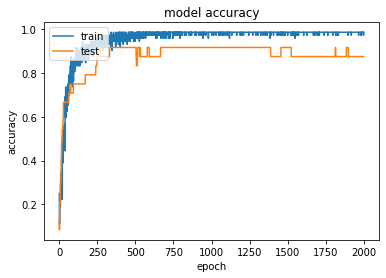

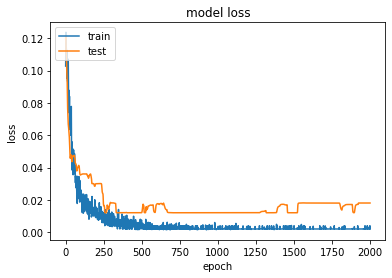

Create confusion matrix over test set


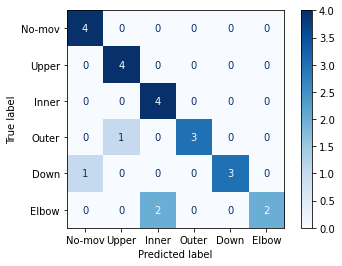

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.6667    1.0000    0.8000         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.5000    0.6667         4

    accuracy                         0.8333        24
   macro avg     0.8778    0.8333    0.8265        24
weighted avg     0.8778    0.8333    0.8265        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   1.   0.75 0.75 0.5 ]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

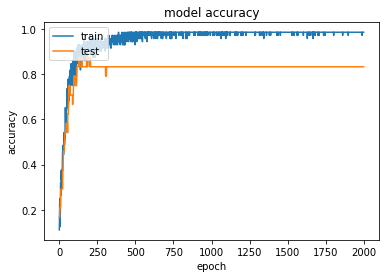

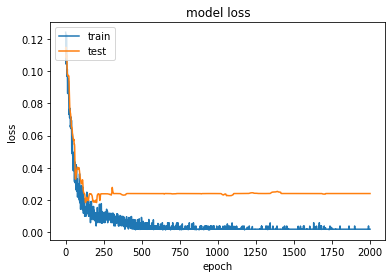

Create confusion matrix over test set


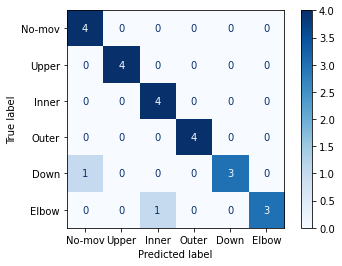

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    1.0000    1.0000         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.9167        24
   macro avg     0.9333    0.9167    0.9153        24
weighted avg     0.9333    0.9167    0.9153        24

Overall accuracy: 0.9166666666666666
Accuracy per class: [1.   1.   1.   1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

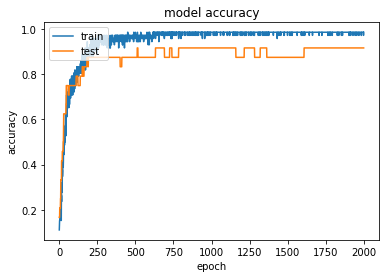

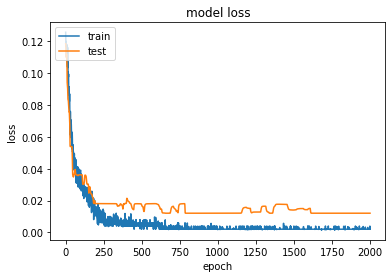

Create confusion matrix over test set


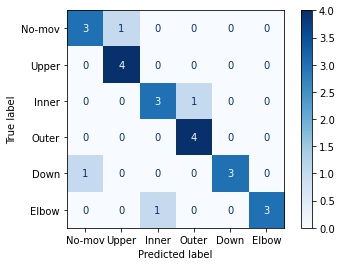

              precision    recall  f1-score   support

      No-mov     0.7500    0.7500    0.7500         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8500    0.8333    0.8320        24
weighted avg     0.8500    0.8333    0.8320        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [0.75 1.   0.75 1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

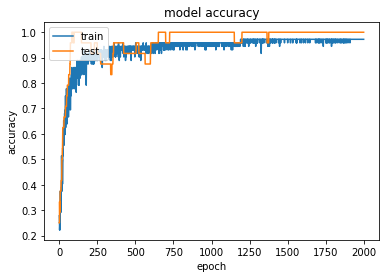

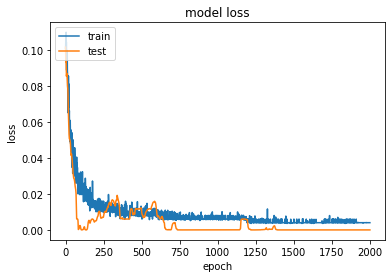

Create confusion matrix over test set


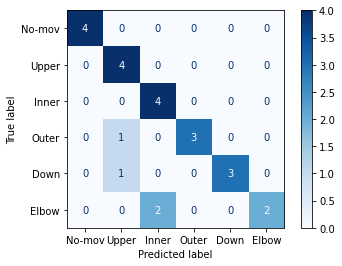

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.6667    1.0000    0.8000         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.5000    0.6667         4

    accuracy                         0.8333        24
   macro avg     0.8889    0.8333    0.8302        24
weighted avg     0.8889    0.8333    0.8302        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   1.   0.75 0.75 0.5 ]
Saved model to disk
Mean accuracy training: 0.982638880610466
Mean accuracy validation: 0.90625
Mean accuracy test: 0.8541666666666667
Mean time: 59.0993989109993
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0  

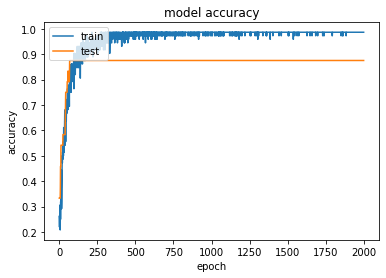

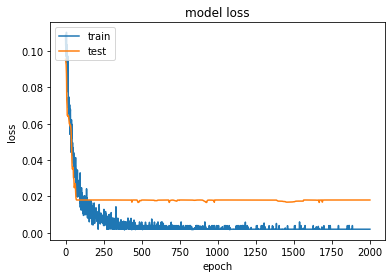

Create confusion matrix over test set


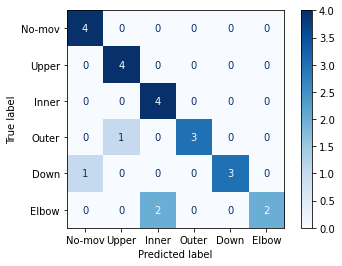

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.6667    1.0000    0.8000         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.5000    0.6667         4

    accuracy                         0.8333        24
   macro avg     0.8778    0.8333    0.8265        24
weighted avg     0.8778    0.8333    0.8265        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   1.   0.75 0.75 0.5 ]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

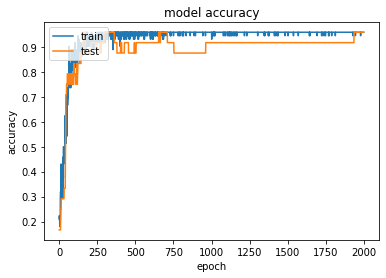

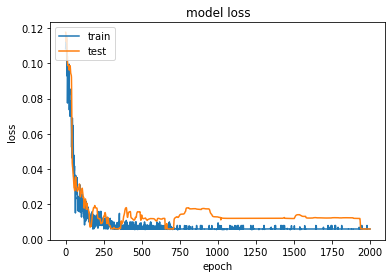

Create confusion matrix over test set


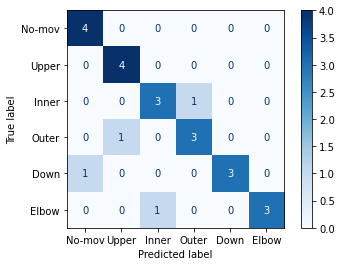

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8500    0.8333    0.8320        24
weighted avg     0.8500    0.8333    0.8320        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

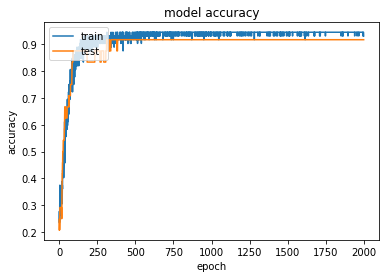

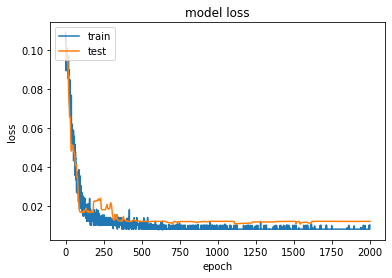

Create confusion matrix over test set


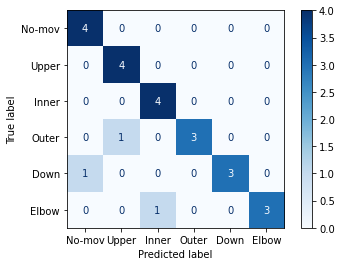

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.9000    0.8750    0.8730        24
weighted avg     0.9000    0.8750    0.8730        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   1.   0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
                

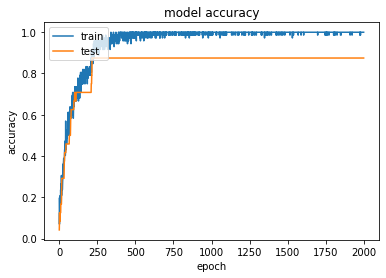

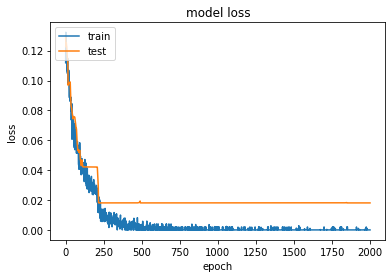

Create confusion matrix over test set


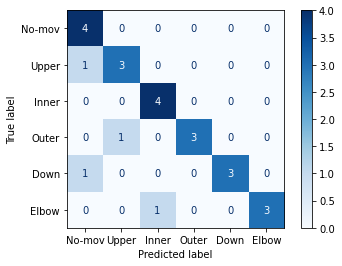

              precision    recall  f1-score   support

      No-mov     0.6667    1.0000    0.8000         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8694    0.8333    0.8351        24
weighted avg     0.8694    0.8333    0.8351        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   0.75 1.   0.75 0.75 0.75]
Saved model to disk
Mean accuracy training: 0.96875
Mean accuracy validation: 0.90625
Mean accuracy test: 0.84375
Mean time: 59.969218134880066
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
           

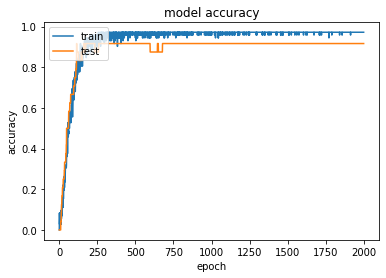

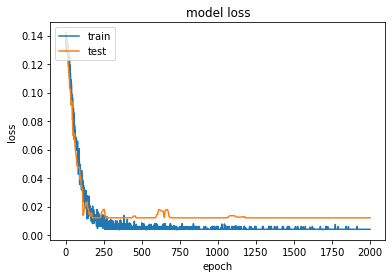

Create confusion matrix over test set


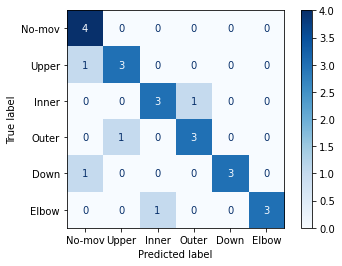

              precision    recall  f1-score   support

      No-mov     0.6667    1.0000    0.8000         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.7917        24
   macro avg     0.8194    0.7917    0.7940        24
weighted avg     0.8194    0.7917    0.7940        24

Overall accuracy: 0.7916666666666666
Accuracy per class: [1.   0.75 0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

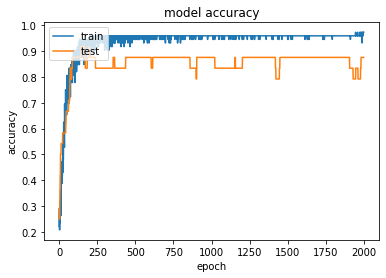

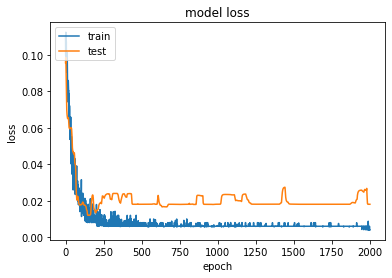

Create confusion matrix over test set


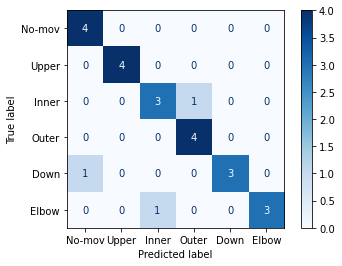

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
                

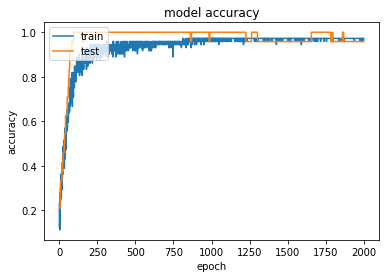

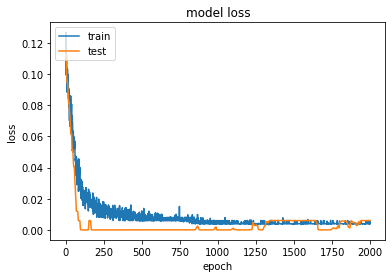

Create confusion matrix over test set


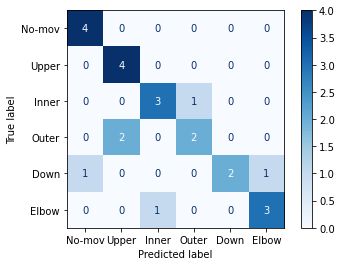

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.6667    0.5000    0.5714         4
        Down     1.0000    0.5000    0.6667         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.7500        24
   macro avg     0.7722    0.7500    0.7378        24
weighted avg     0.7722    0.7500    0.7378        24

Overall accuracy: 0.75
Accuracy per class: [1.   1.   0.75 0.5  0.5  0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
                 

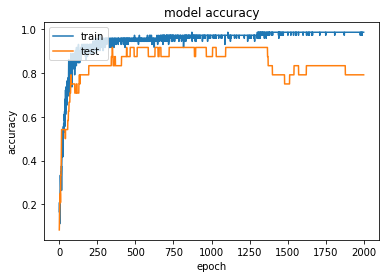

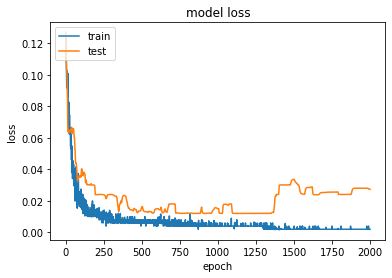

Create confusion matrix over test set


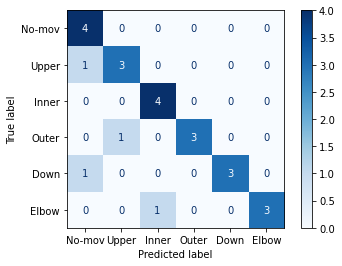

              precision    recall  f1-score   support

      No-mov     0.6667    1.0000    0.8000         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8694    0.8333    0.8351        24
weighted avg     0.8694    0.8333    0.8351        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   0.75 1.   0.75 0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9756944328546524
Mean accuracy validation: 0.8854166716337204
Mean accuracy test: 0.8125
Mean time: 58.61578392982483
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0 

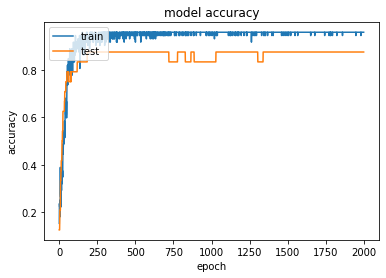

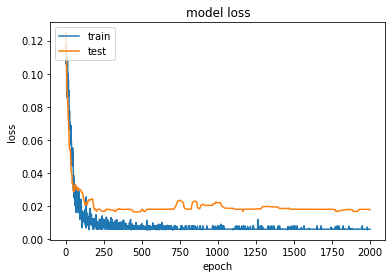

Create confusion matrix over test set


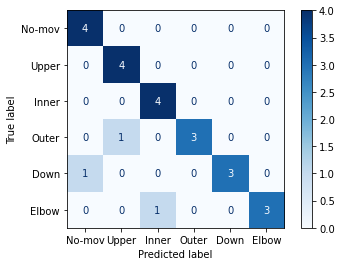

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.9000    0.8750    0.8730        24
weighted avg     0.9000    0.8750    0.8730        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   1.   0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
                

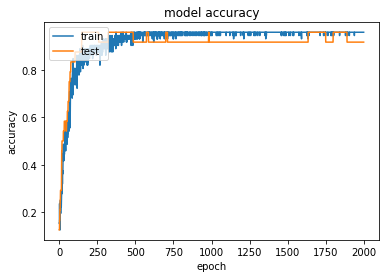

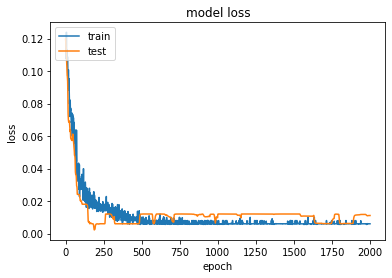

Create confusion matrix over test set


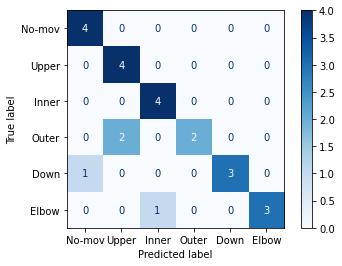

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    0.5000    0.6667         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8778    0.8333    0.8265        24
weighted avg     0.8778    0.8333    0.8265        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   1.   0.5  0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

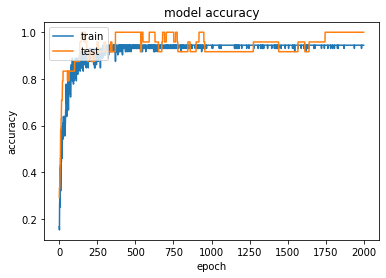

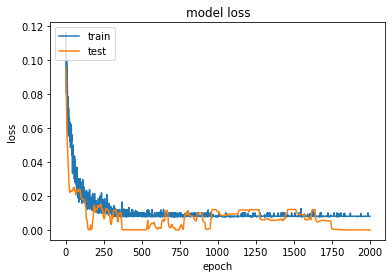

Create confusion matrix over test set


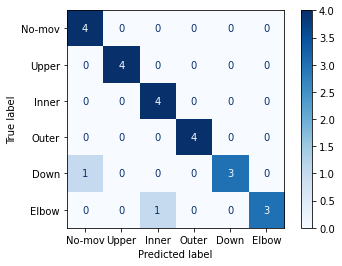

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    1.0000    1.0000         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.9167        24
   macro avg     0.9333    0.9167    0.9153        24
weighted avg     0.9333    0.9167    0.9153        24

Overall accuracy: 0.9166666666666666
Accuracy per class: [1.   1.   1.   1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

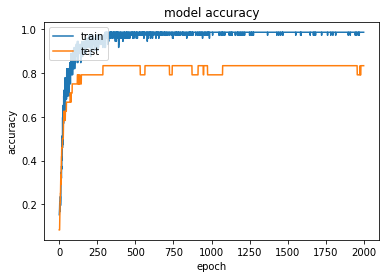

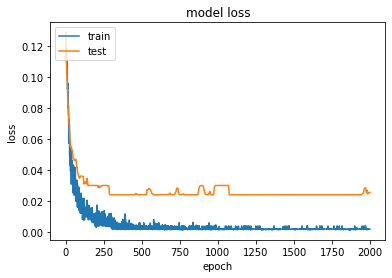

Create confusion matrix over test set


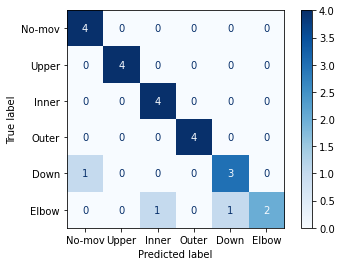

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    1.0000    1.0000         4
        Down     0.7500    0.7500    0.7500         4
       Elbow     1.0000    0.5000    0.6667         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8657        24
weighted avg     0.8917    0.8750    0.8657        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   1.   1.   0.75 0.5 ]
Saved model to disk
Mean accuracy training: 0.9618055373430252
Mean accuracy validation: 0.90625
Mean accuracy test: 0.875
Mean time: 59.02966123819351
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                

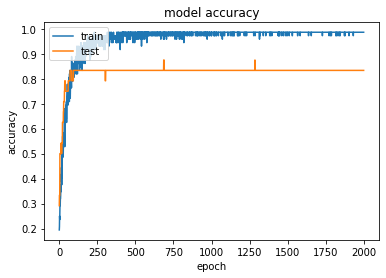

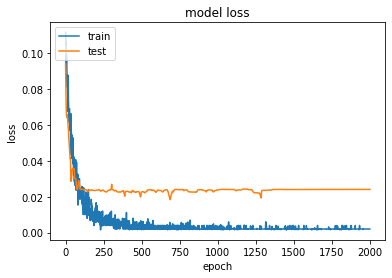

Create confusion matrix over test set


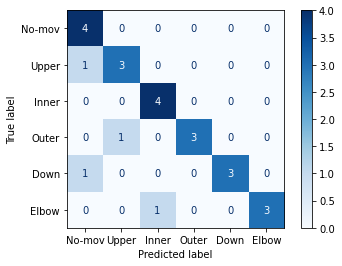

              precision    recall  f1-score   support

      No-mov     0.6667    1.0000    0.8000         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8694    0.8333    0.8351        24
weighted avg     0.8694    0.8333    0.8351        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   0.75 1.   0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
   

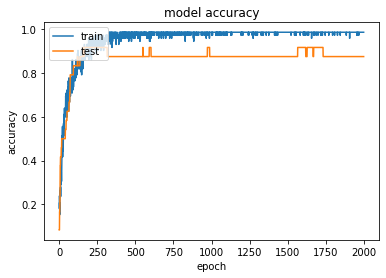

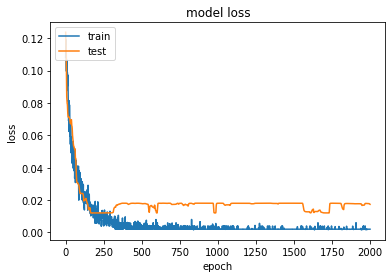

Create confusion matrix over test set


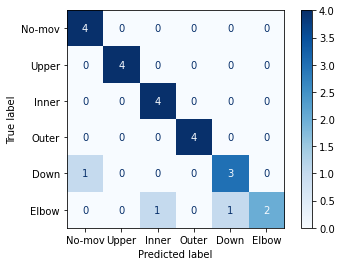

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    1.0000    1.0000         4
        Down     0.7500    0.7500    0.7500         4
       Elbow     1.0000    0.5000    0.6667         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8657        24
weighted avg     0.8917    0.8750    0.8657        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   1.   1.   0.75 0.5 ]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
                

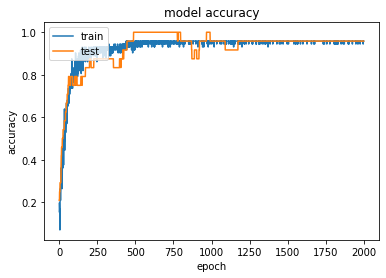

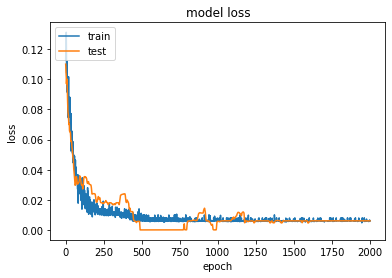

Create confusion matrix over test set


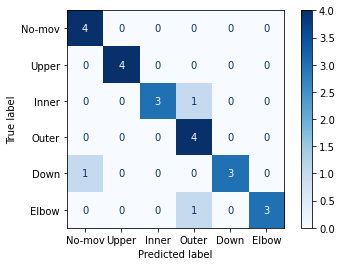

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     1.0000    0.7500    0.8571         4
       Outer     0.6667    1.0000    0.8000         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.9111    0.8750    0.8767        24
weighted avg     0.9111    0.8750    0.8767        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 flatten (Flatten)           (None, 972)               0         
                

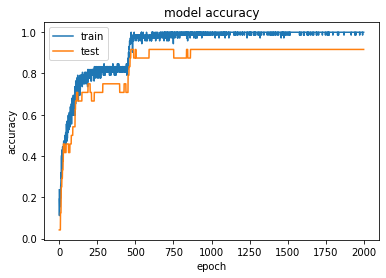

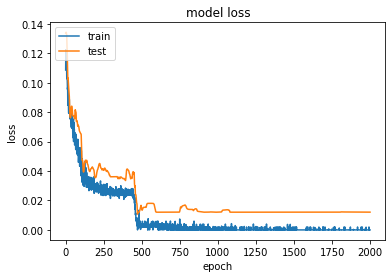

Create confusion matrix over test set


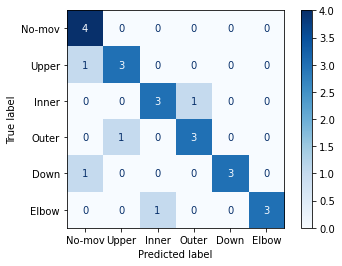

              precision    recall  f1-score   support

      No-mov     0.6667    1.0000    0.8000         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.7917        24
   macro avg     0.8194    0.7917    0.7940        24
weighted avg     0.8194    0.7917    0.7940        24

Overall accuracy: 0.7916666666666666
Accuracy per class: [1.   0.75 0.75 0.75 0.75 0.75]
Saved model to disk
Mean accuracy training: 0.982638880610466
Mean accuracy validation: 0.8958333283662796
Mean accuracy test: 0.84375
Mean time: 58.81024944782257
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0 

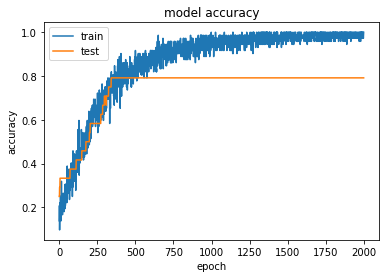

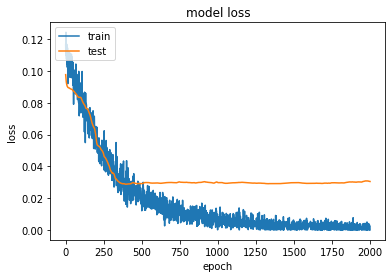

Create confusion matrix over test set


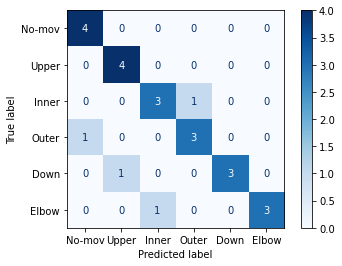

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8500    0.8333    0.8320        24
weighted avg     0.8500    0.8333    0.8320        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

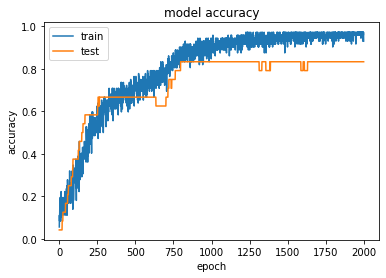

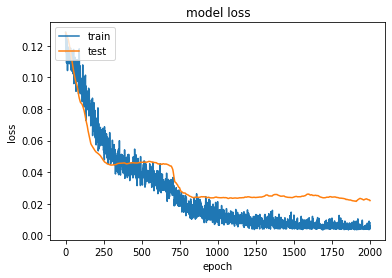

Create confusion matrix over test set


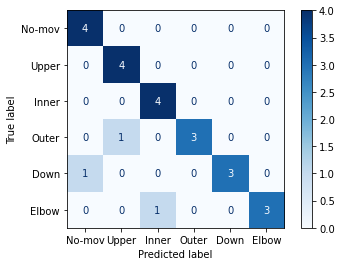

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.9000    0.8750    0.8730        24
weighted avg     0.9000    0.8750    0.8730        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   1.   0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
                

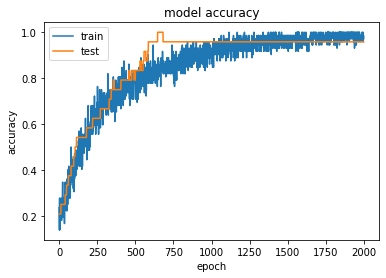

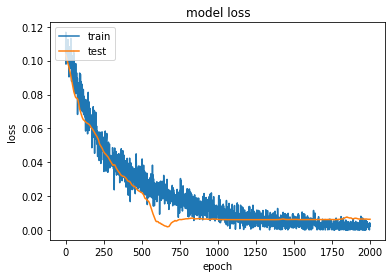

Create confusion matrix over test set


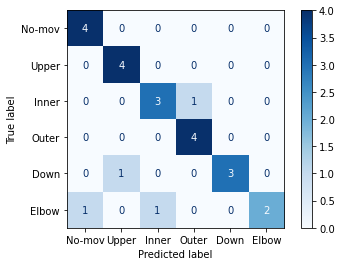

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.5000    0.6667         4

    accuracy                         0.8333        24
   macro avg     0.8583    0.8333    0.8234        24
weighted avg     0.8583    0.8333    0.8234        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 1.   0.75 0.5 ]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

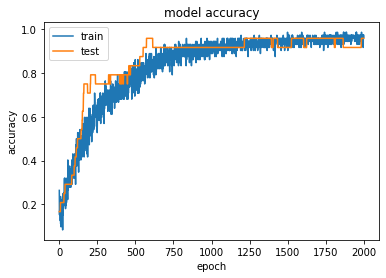

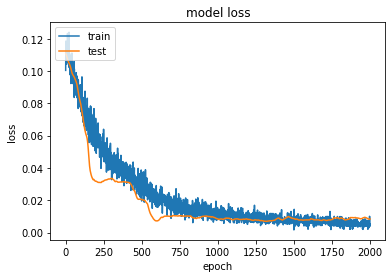

Create confusion matrix over test set


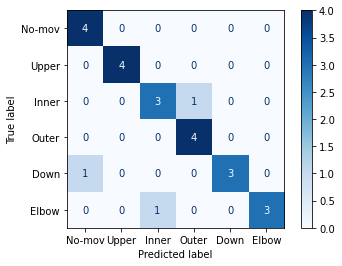

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Mean accuracy training: 0.96875
Mean accuracy validation: 0.8854166567325592
Mean accuracy test: 0.8541666666666667
Mean time: 48.77020835876465
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
   

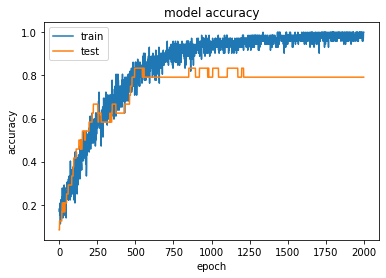

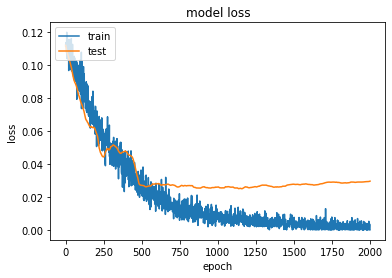

Create confusion matrix over test set


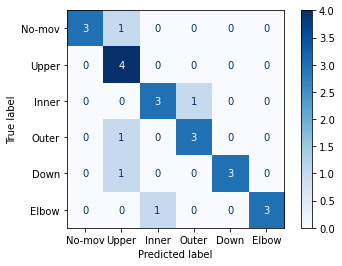

              precision    recall  f1-score   support

      No-mov     1.0000    0.7500    0.8571         4
       Upper     0.5714    1.0000    0.7273         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.7917        24
   macro avg     0.8452    0.7917    0.7998        24
weighted avg     0.8452    0.7917    0.7998        24

Overall accuracy: 0.7916666666666666
Accuracy per class: [0.75 1.   0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

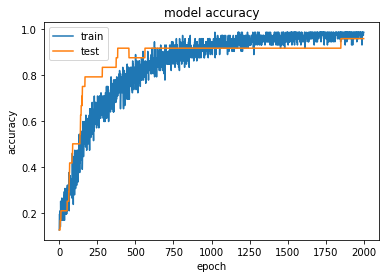

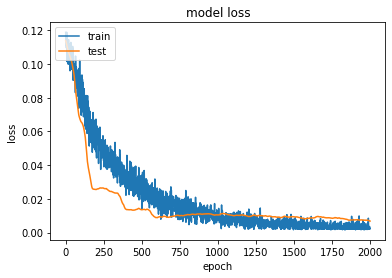

Create confusion matrix over test set


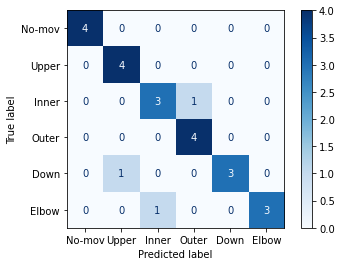

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
                

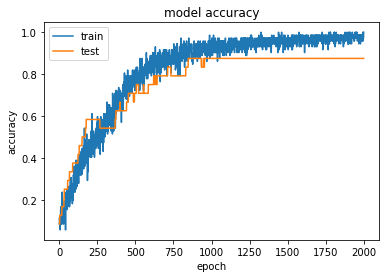

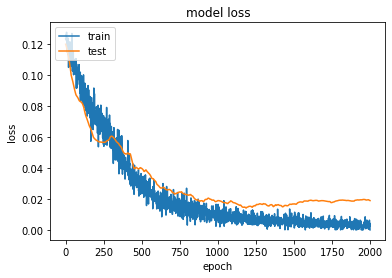

Create confusion matrix over test set


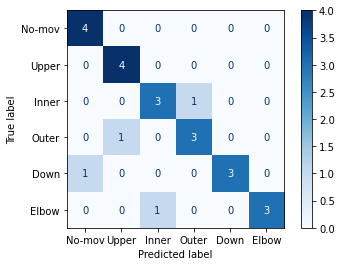

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8500    0.8333    0.8320        24
weighted avg     0.8500    0.8333    0.8320        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

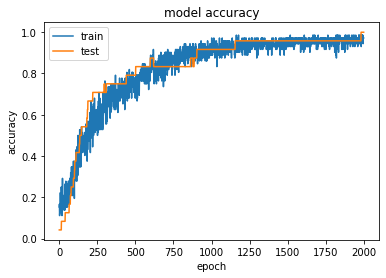

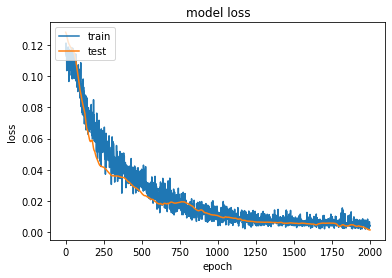

Create confusion matrix over test set


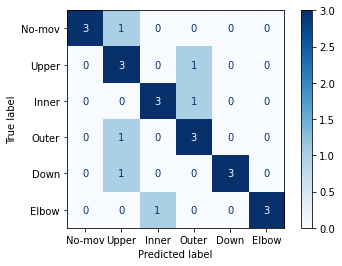

              precision    recall  f1-score   support

      No-mov     1.0000    0.7500    0.8571         4
       Upper     0.5000    0.7500    0.6000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.6000    0.7500    0.6667         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.7500        24
   macro avg     0.8083    0.7500    0.7647        24
weighted avg     0.8083    0.7500    0.7647        24

Overall accuracy: 0.75
Accuracy per class: [0.75 0.75 0.75 0.75 0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9895833283662796
Mean accuracy validation: 0.90625
Mean accuracy test: 0.8125
Mean time: 48.418195605278015
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
               

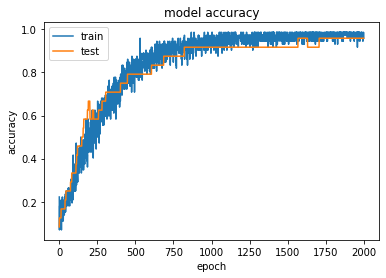

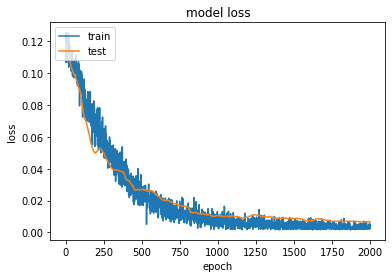

Create confusion matrix over test set


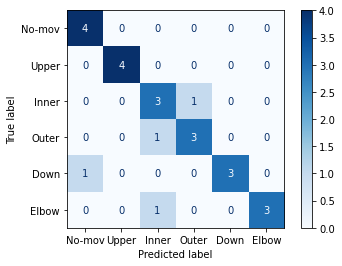

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.6000    0.7500    0.6667         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8583    0.8333    0.8366        24
weighted avg     0.8583    0.8333    0.8366        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

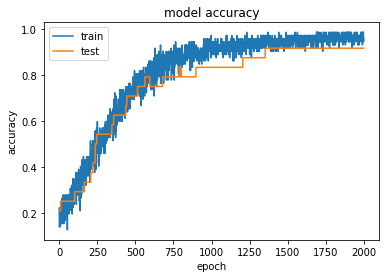

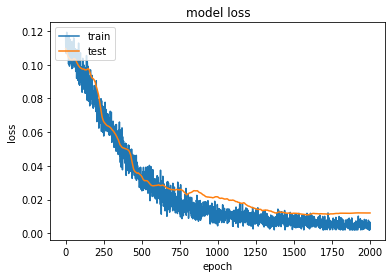

Create confusion matrix over test set


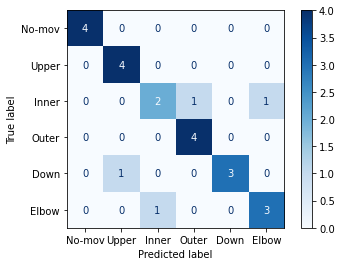

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.6667    0.5000    0.5714         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.8333        24
   macro avg     0.8361    0.8333    0.8261        24
weighted avg     0.8361    0.8333    0.8261        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.5  1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

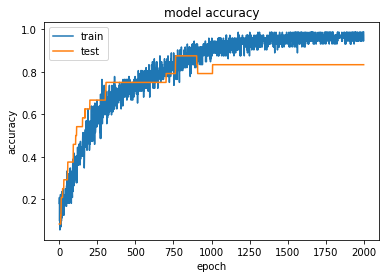

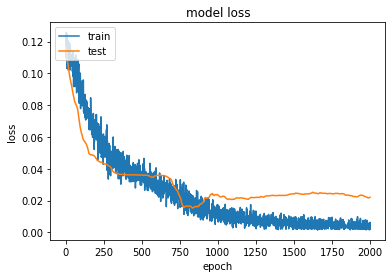

Create confusion matrix over test set


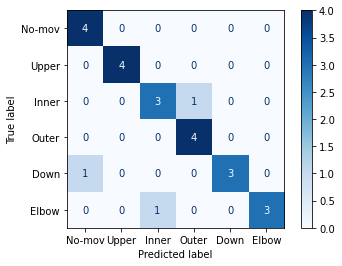

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
                

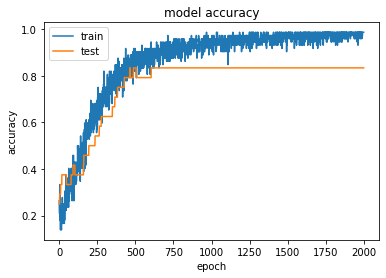

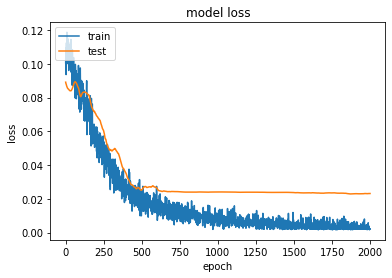

Create confusion matrix over test set


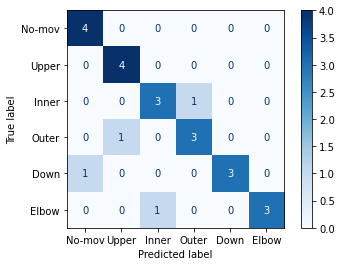

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8500    0.8333    0.8320        24
weighted avg     0.8500    0.8333    0.8320        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9722222089767456
Mean accuracy validation: 0.8854166567325592
Mean accuracy test: 0.84375
Mean time: 56.38028711080551
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0

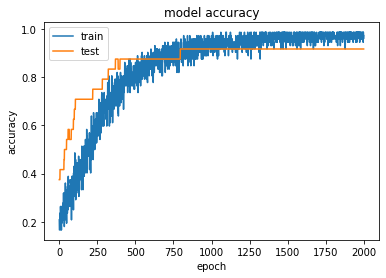

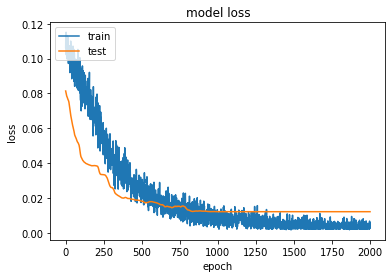

Create confusion matrix over test set


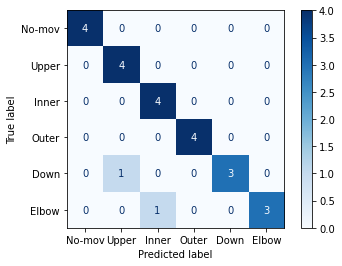

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    1.0000    1.0000         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.9167        24
   macro avg     0.9333    0.9167    0.9153        24
weighted avg     0.9333    0.9167    0.9153        24

Overall accuracy: 0.9166666666666666
Accuracy per class: [1.   1.   1.   1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

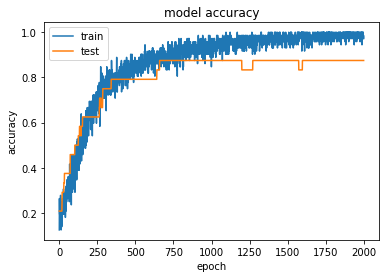

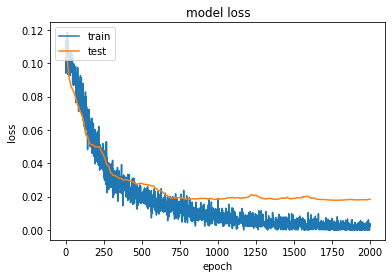

Create confusion matrix over test set


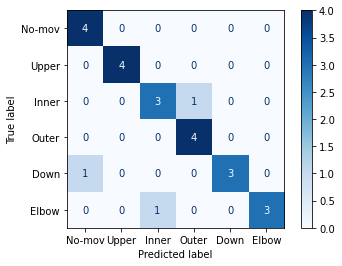

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
                

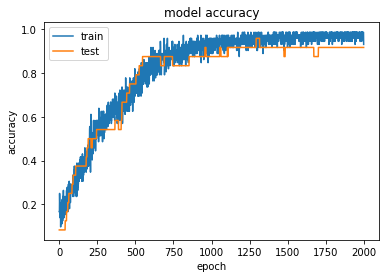

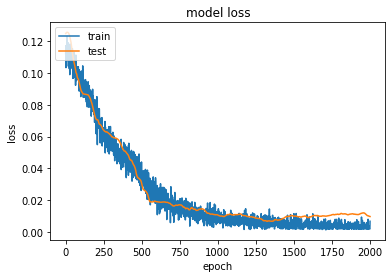

Create confusion matrix over test set


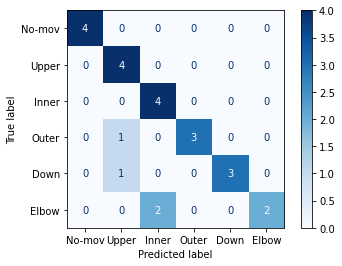

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.6667    1.0000    0.8000         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.5000    0.6667         4

    accuracy                         0.8333        24
   macro avg     0.8889    0.8333    0.8302        24
weighted avg     0.8889    0.8333    0.8302        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   1.   0.75 0.75 0.5 ]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

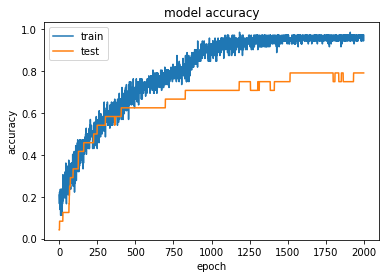

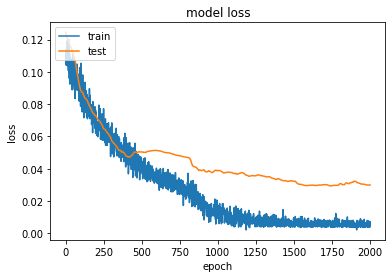

Create confusion matrix over test set


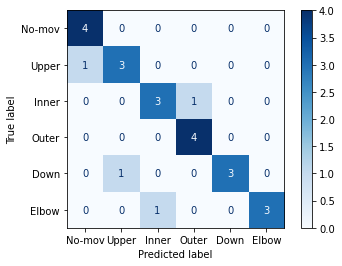

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8500    0.8333    0.8320        24
weighted avg     0.8500    0.8333    0.8320        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   0.75 0.75 1.   0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9618055522441864
Mean accuracy validation: 0.8750000149011612
Mean accuracy test: 0.8645833333333334
Mean time: 49.54825460910797
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]

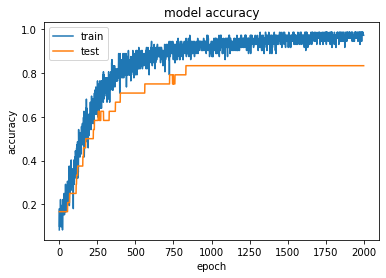

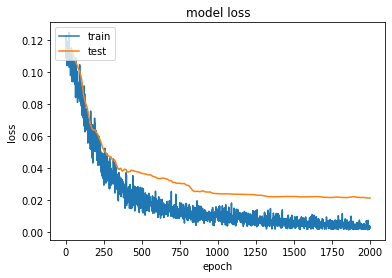

Create confusion matrix over test set


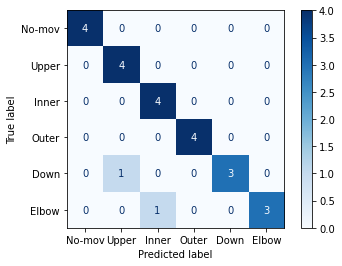

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    1.0000    1.0000         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.9167        24
   macro avg     0.9333    0.9167    0.9153        24
weighted avg     0.9333    0.9167    0.9153        24

Overall accuracy: 0.9166666666666666
Accuracy per class: [1.   1.   1.   1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

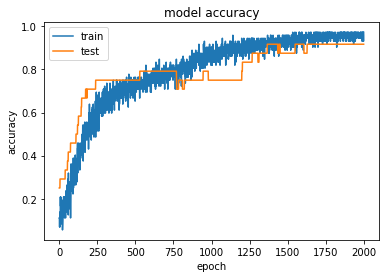

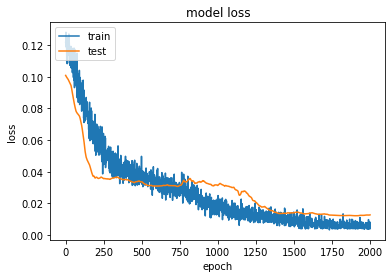

Create confusion matrix over test set


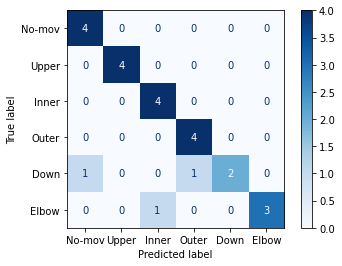

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     1.0000    1.0000    1.0000         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.5000    0.6667         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.9000    0.8750    0.8651        24
weighted avg     0.9000    0.8750    0.8651        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   1.   1.   0.5  0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
                

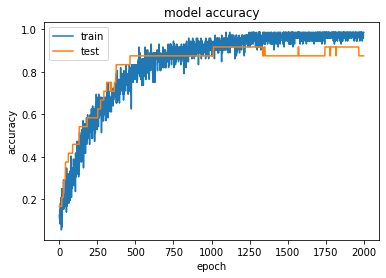

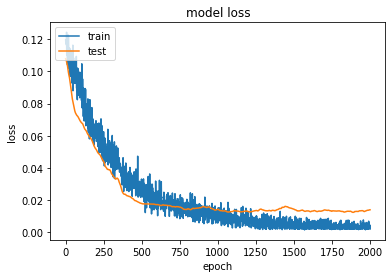

Create confusion matrix over test set


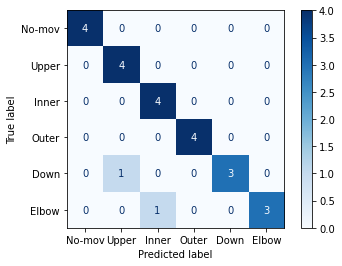

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    1.0000    1.0000         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.9167        24
   macro avg     0.9333    0.9167    0.9153        24
weighted avg     0.9333    0.9167    0.9153        24

Overall accuracy: 0.9166666666666666
Accuracy per class: [1.   1.   1.   1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            8672      
   

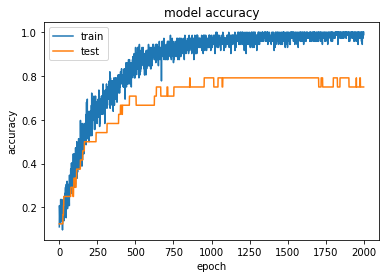

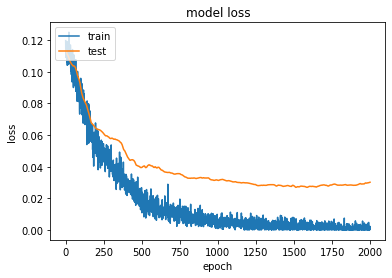

Create confusion matrix over test set


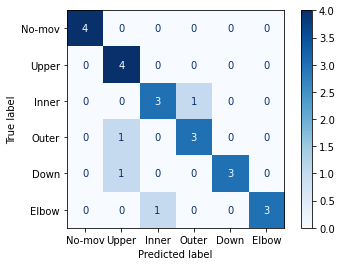

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8611    0.8333    0.8357        24
weighted avg     0.8611    0.8333    0.8357        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Mean accuracy training: 0.982638880610466
Mean accuracy validation: 0.84375
Mean accuracy test: 0.8854166666666666
Mean time: 49.196184396743774
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0

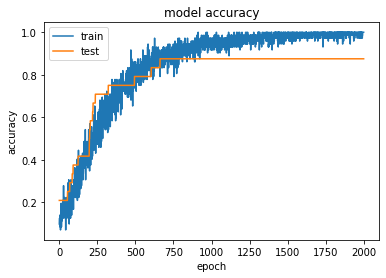

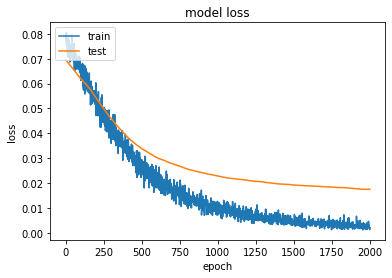

Create confusion matrix over test set


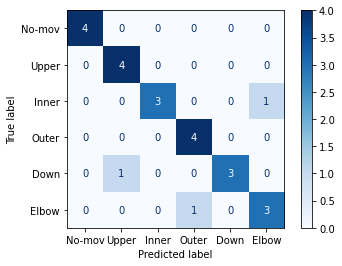

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     1.0000    0.7500    0.8571         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
                

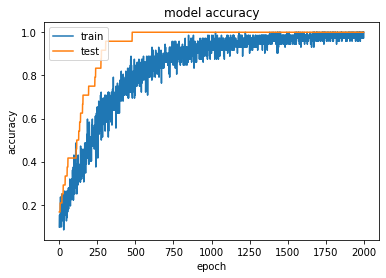

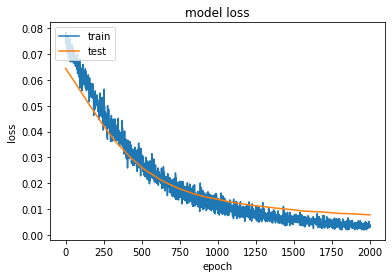

Create confusion matrix over test set


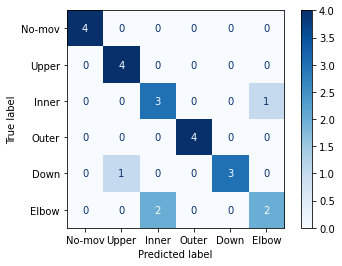

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.6000    0.7500    0.6667         4
       Outer     1.0000    1.0000    1.0000         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     0.6667    0.5000    0.5714         4

    accuracy                         0.8333        24
   macro avg     0.8444    0.8333    0.8307        24
weighted avg     0.8444    0.8333    0.8307        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 1.   0.75 0.5 ]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

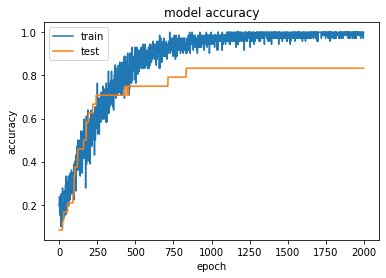

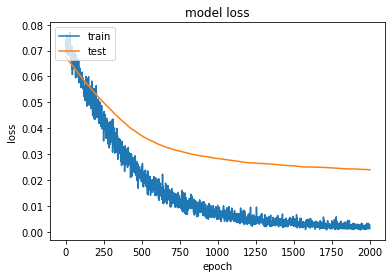

Create confusion matrix over test set


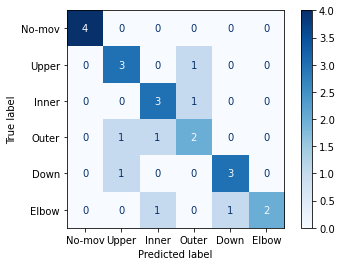

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6000    0.7500    0.6667         4
       Inner     0.6000    0.7500    0.6667         4
       Outer     0.5000    0.5000    0.5000         4
        Down     0.7500    0.7500    0.7500         4
       Elbow     1.0000    0.5000    0.6667         4

    accuracy                         0.7083        24
   macro avg     0.7417    0.7083    0.7083        24
weighted avg     0.7417    0.7083    0.7083        24

Overall accuracy: 0.7083333333333334
Accuracy per class: [1.   0.75 0.75 0.5  0.75 0.5 ]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

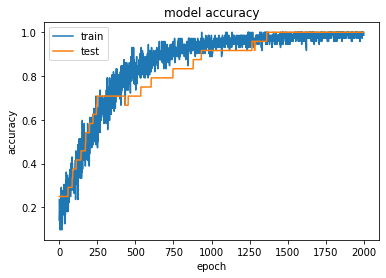

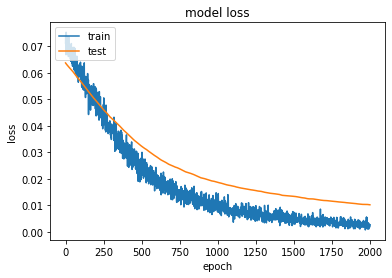

Create confusion matrix over test set


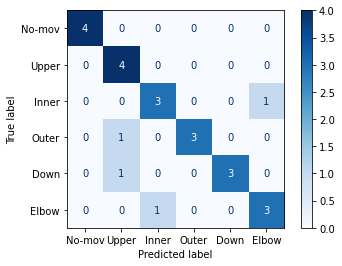

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.8333        24
   macro avg     0.8611    0.8333    0.8357        24
weighted avg     0.8611    0.8333    0.8357        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9965277761220932
Mean accuracy validation: 0.9270833283662796
Mean accuracy test: 0.8125
Mean time: 76.9645876288414
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0  

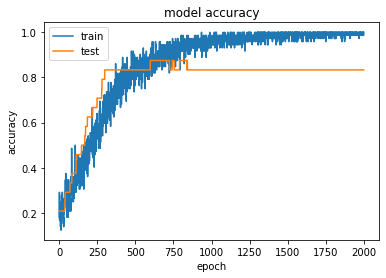

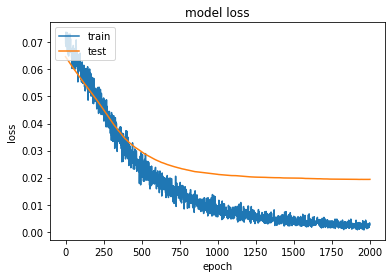

Create confusion matrix over test set


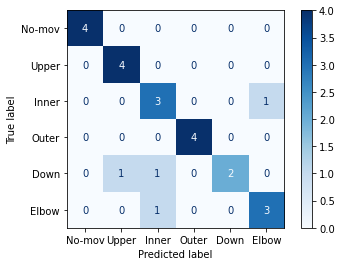

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.6000    0.7500    0.6667         4
       Outer     1.0000    1.0000    1.0000         4
        Down     1.0000    0.5000    0.6667         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.8333        24
   macro avg     0.8583    0.8333    0.8287        24
weighted avg     0.8583    0.8333    0.8287        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 1.   0.5  0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

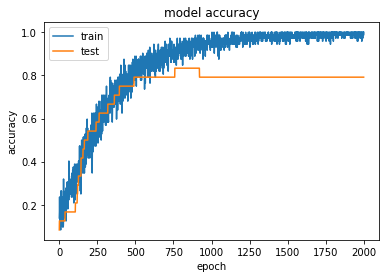

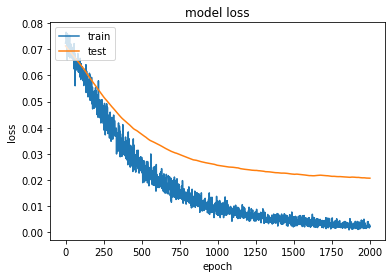

Create confusion matrix over test set


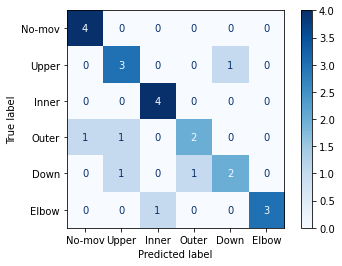

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.6000    0.7500    0.6667         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     0.6667    0.5000    0.5714         4
        Down     0.6667    0.5000    0.5714         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.7500        24
   macro avg     0.7556    0.7500    0.7407        24
weighted avg     0.7556    0.7500    0.7407        24

Overall accuracy: 0.75
Accuracy per class: [1.   0.75 1.   0.5  0.5  0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
                 

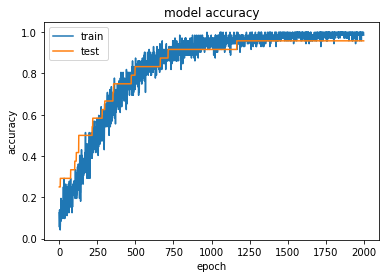

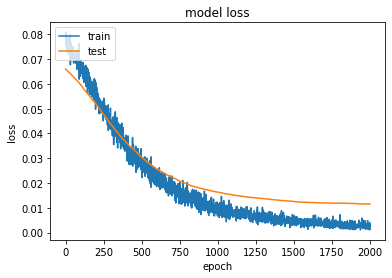

Create confusion matrix over test set


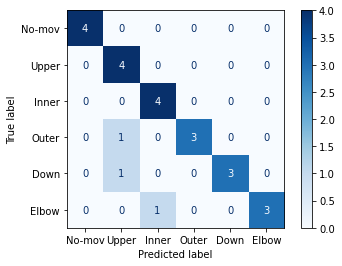

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.9111    0.8750    0.8767        24
weighted avg     0.9111    0.8750    0.8767        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   1.   0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
                

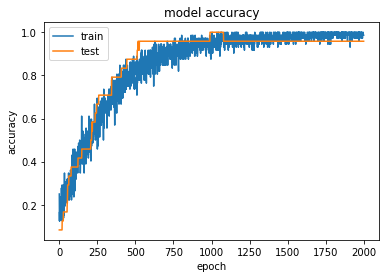

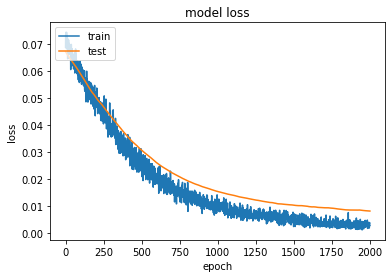

Create confusion matrix over test set


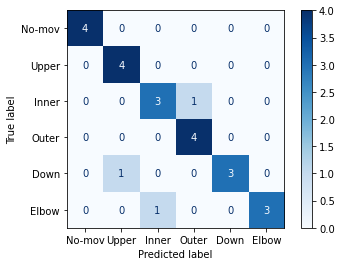

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9930555522441864
Mean accuracy validation: 0.8854166567325592
Mean accuracy test: 0.8333333333333334
Mean time: 78.5514942407608
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0   

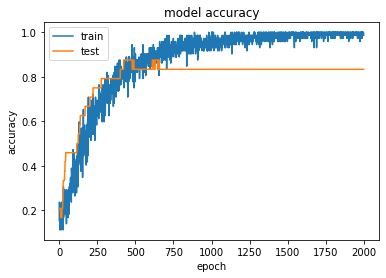

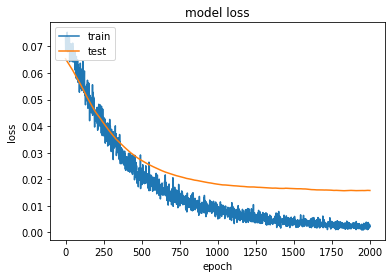

Create confusion matrix over test set


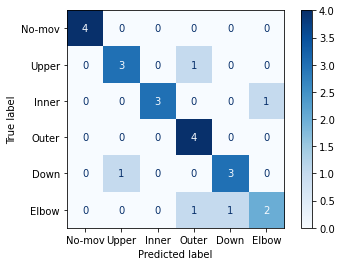

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     1.0000    0.7500    0.8571         4
       Outer     0.6667    1.0000    0.8000         4
        Down     0.7500    0.7500    0.7500         4
       Elbow     0.6667    0.5000    0.5714         4

    accuracy                         0.7917        24
   macro avg     0.8056    0.7917    0.7881        24
weighted avg     0.8056    0.7917    0.7881        24

Overall accuracy: 0.7916666666666666
Accuracy per class: [1.   0.75 0.75 1.   0.75 0.5 ]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

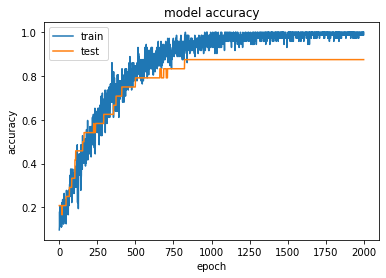

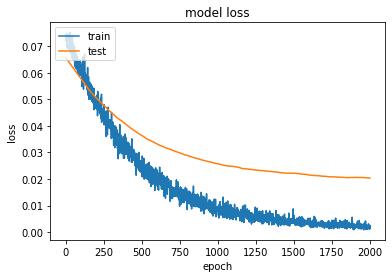

Create confusion matrix over test set


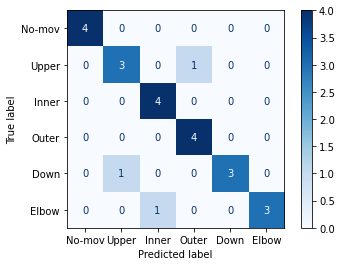

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   0.75 1.   1.   0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
                

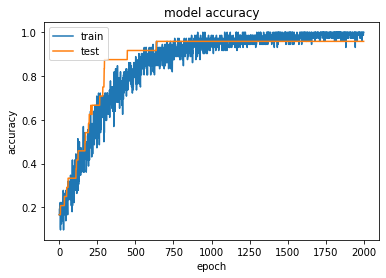

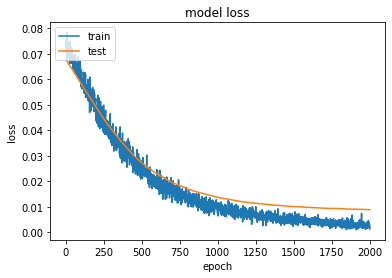

Create confusion matrix over test set


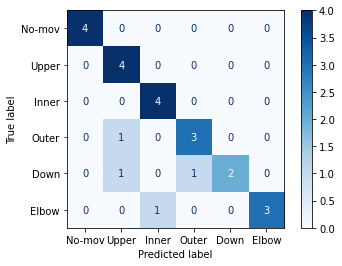

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.5000    0.6667         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8694    0.8333    0.8271        24
weighted avg     0.8694    0.8333    0.8271        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   1.   0.75 0.5  0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

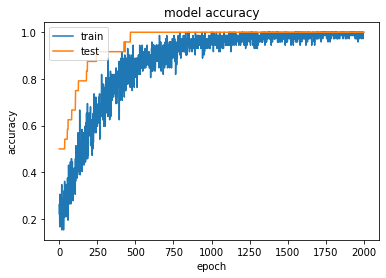

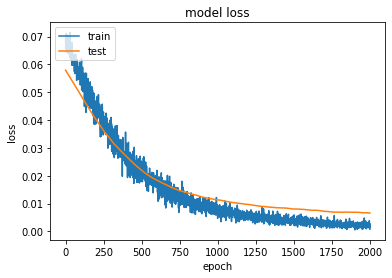

Create confusion matrix over test set


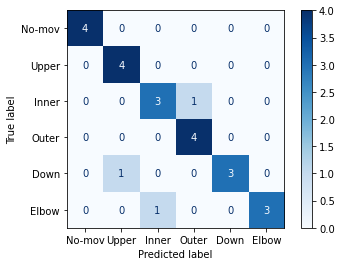

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   1.   0.75 1.   0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9965277761220932
Mean accuracy validation: 0.9166666567325592
Mean accuracy test: 0.84375
Mean time: 79.98652797937393
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
   

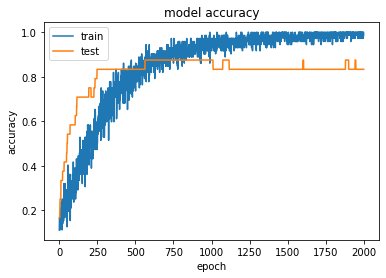

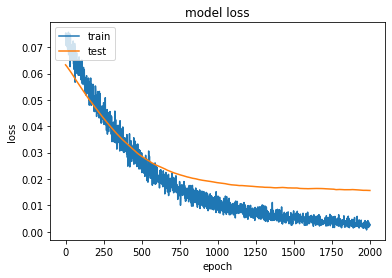

Create confusion matrix over test set


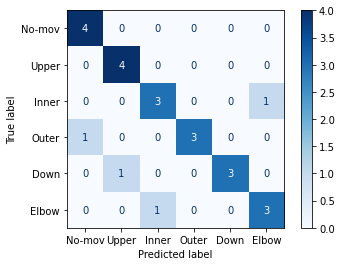

              precision    recall  f1-score   support

      No-mov     0.8000    1.0000    0.8889         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.8333        24
   macro avg     0.8500    0.8333    0.8320        24
weighted avg     0.8500    0.8333    0.8320        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

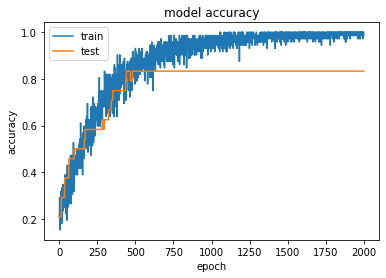

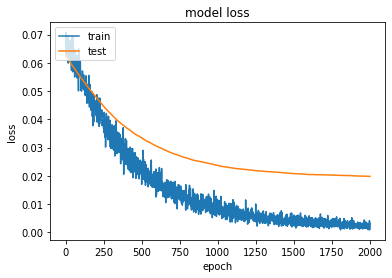

Create confusion matrix over test set


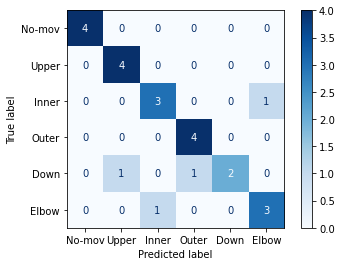

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.5000    0.6667         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.8333        24
   macro avg     0.8500    0.8333    0.8241        24
weighted avg     0.8500    0.8333    0.8241        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 1.   0.5  0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

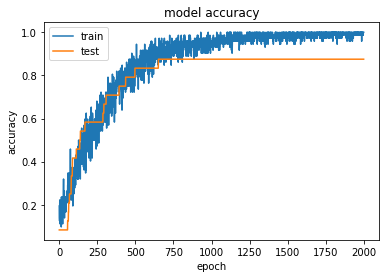

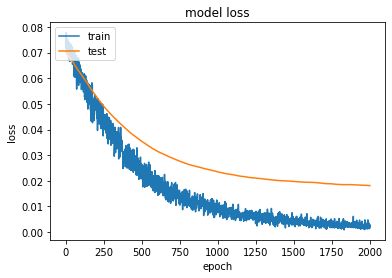

Create confusion matrix over test set


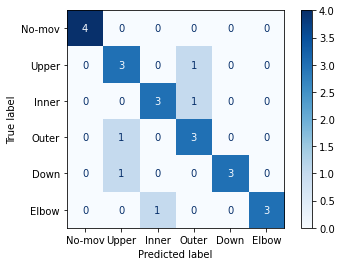

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6000    0.7500    0.6667         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.6000    0.7500    0.6667         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.7917        24
   macro avg     0.8250    0.7917    0.7996        24
weighted avg     0.8250    0.7917    0.7996        24

Overall accuracy: 0.7916666666666666
Accuracy per class: [1.   0.75 0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

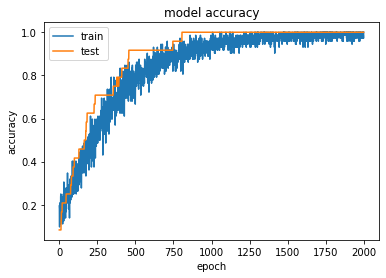

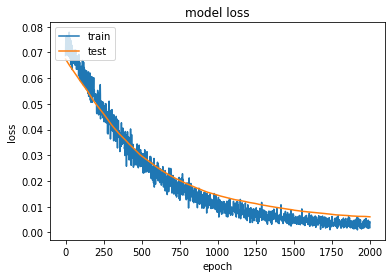

Create confusion matrix over test set


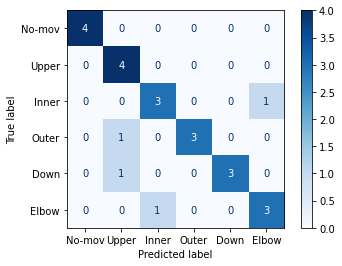

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.8333        24
   macro avg     0.8611    0.8333    0.8357        24
weighted avg     0.8611    0.8333    0.8357        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9930555522441864
Mean accuracy validation: 0.8854166567325592
Mean accuracy test: 0.8229166666666667
Mean time: 183.56878453493118
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)

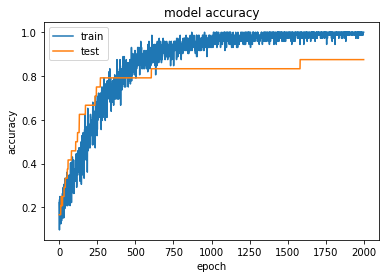

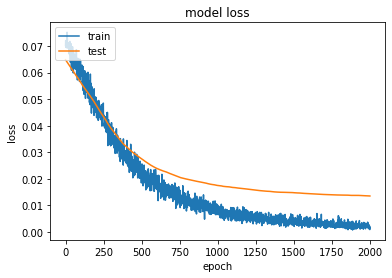

Create confusion matrix over test set


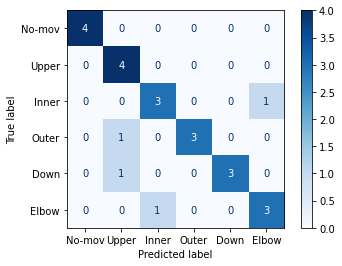

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     1.0000    0.7500    0.8571         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     0.7500    0.7500    0.7500         4

    accuracy                         0.8333        24
   macro avg     0.8611    0.8333    0.8357        24
weighted avg     0.8611    0.8333    0.8357        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

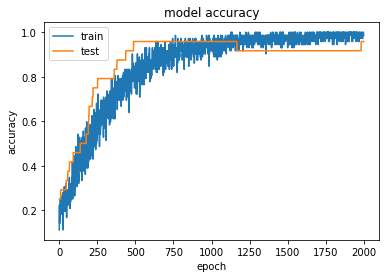

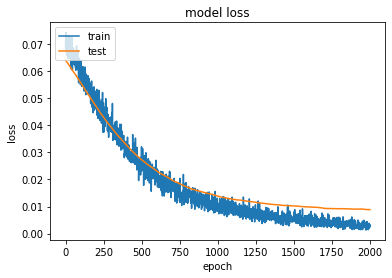

Create confusion matrix over test set


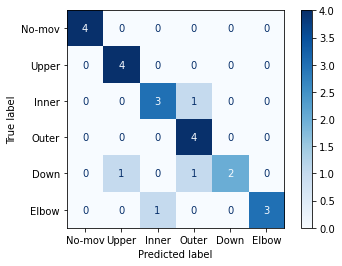

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.8000    1.0000    0.8889         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.6667    1.0000    0.8000         4
        Down     1.0000    0.5000    0.6667         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8694    0.8333    0.8271        24
weighted avg     0.8694    0.8333    0.8271        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 1.   0.5  0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

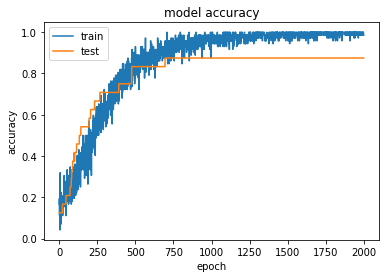

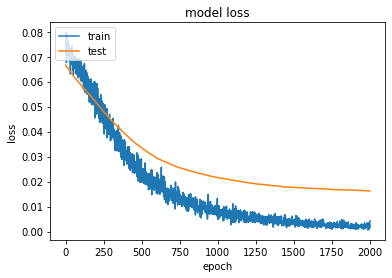

Create confusion matrix over test set


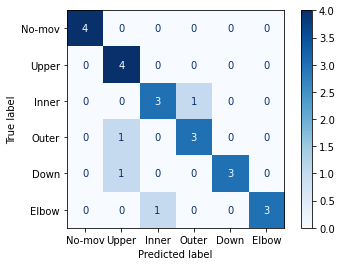

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.6667    1.0000    0.8000         4
       Inner     0.7500    0.7500    0.7500         4
       Outer     0.7500    0.7500    0.7500         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8333        24
   macro avg     0.8611    0.8333    0.8357        24
weighted avg     0.8611    0.8333    0.8357        24

Overall accuracy: 0.8333333333333334
Accuracy per class: [1.   1.   0.75 0.75 0.75 0.75]
Saved model to disk
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 54)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 32)            11136     
   

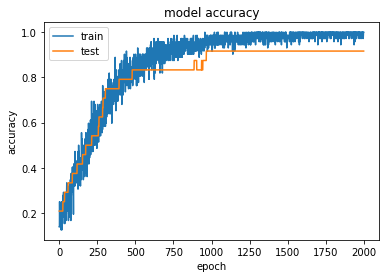

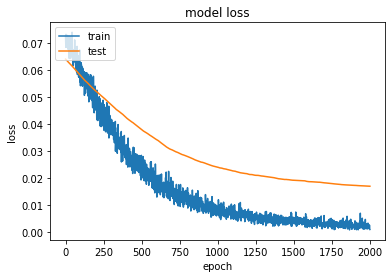

Create confusion matrix over test set


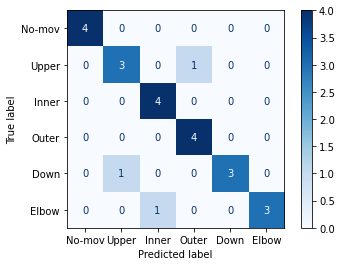

              precision    recall  f1-score   support

      No-mov     1.0000    1.0000    1.0000         4
       Upper     0.7500    0.7500    0.7500         4
       Inner     0.8000    1.0000    0.8889         4
       Outer     0.8000    1.0000    0.8889         4
        Down     1.0000    0.7500    0.8571         4
       Elbow     1.0000    0.7500    0.8571         4

    accuracy                         0.8750        24
   macro avg     0.8917    0.8750    0.8737        24
weighted avg     0.8917    0.8750    0.8737        24

Overall accuracy: 0.875
Accuracy per class: [1.   0.75 1.   1.   0.75 0.75]
Saved model to disk
Mean accuracy training: 0.9930555522441864
Mean accuracy validation: 0.90625
Mean accuracy test: 0.84375
Mean time: 80.4820625782013


In [ ]:
for chosen_model in batch_chosen_model:
  for ewma_b in batch_ewma_b:
    for adam_learning_rate in batch_learning_rate:
      # Return to content dir.
      os.chdir('/content/out')

      # Recalculate EWMA, using logaritmicaly sampled points
      X_smooth = applyEWMA(ewma, X_norm)
      X_expanded = []
      for example in X_smooth:
        resExample = pad_sequences(example, padding='post', maxlen=maxLength, dtype='float64')
        X_expanded.append(resExample)

      # Create directory.
      output_dir = chosen_model + "/norm-" + str(norm) + "/ewma-" + str(ewma_b) + "/lr-" + str(adam_learning_rate) + "/"
      if not os.path.exists(output_dir):
          os.makedirs(output_dir)
          os.chdir(output_dir)

      if batch_training:
        # Initialize kfolds.
        if(stratified):
          kfold = StratifiedKFold(n_splits=num_folds, random_state=None, shuffle=True)
        else:
          kfold = KFold(n_splits=num_folds, shuffle=True)


      # Define per-fold score containers
      acc_per_fold = []
      val_acc_per_fold = []
      test_acc_per_fold = []
      time_per_fold = []

      # Iterate over folds.
      fold_no = 1

      for train, test in kfold.split(X, np.argmax(Y, axis=1)):

        model = create_model()

        # Instantiate optimizer and compile selected model.
        opt = Adam(learning_rate=adam_learning_rate, decay=adam_decay)
        model.compile(loss=model_loss, optimizer=opt, metrics=["accuracy"])

        # Get timestamp.
        start_time = time.time()

        # Start training. Set verbose to 1 or 2 to print progress.
        history = model.fit(X[train], Y[train],
                            batch_size=model_batch_size, 
                            epochs=model_epochs, verbose=0
                            ,validation_data=(X[test], Y[test]),)

        print(history.history.keys())
        
        total_time = (time.time() - start_time)

        # Print accuracies and time.
        print("---------------------------------------------------------")
        print("Fold " + str(fold_no))
        print("Train acc.: %s" % history.history['accuracy'][-1])
        print("Test acc.: %s" % history.history['val_accuracy'][-1])
        print("Time: %s" % total_time)

        # Save accuracies and time into a file.
        f = open("results" + str(fold_no) + ".txt", "w")
        f.write("Train acc.: " + str(history.history['accuracy'][-1]) + "\n")
        f.write("Test acc.: " + str(history.history['val_accuracy'][-1]) + "\n")
        f.write("Time: " + str(total_time) + "\n")
        f.close()

        # Show data saved in history,
        print(history.history.keys())

        # Show accuracy and save chart into file.
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig('Accuracy-fold-' + str(fold_no) + '.png')
        plt.show()

        # Show loss and save chart into file.
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig('Loss-fold-' + str(fold_no) + '.png')
        plt.show()

        acc_per_fold.append(history.history['accuracy'][-1])
        val_acc_per_fold.append(history.history['val_accuracy'][-1])
        time_per_fold.append(total_time)

        # Confusion matrix and reports
        print("Create confusion matrix over test set")
        labels = ["No-mov", "Upper", "Inner", "Outer", "Down", "Elbow"]

        # Confusion matrix
        Y_pred = model.predict(X_test)
        cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

        disp.plot(cmap=plt.cm.Blues)
        plt.savefig('Confusion-matrix-predicted-' + str(len(Y_pred)) + '-fold-' + str(fold_no) + '.png')
        plt.show()

        # Classification report
        print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=labels, digits=4))
        
        # Overall accuracy
        print("Overall accuracy: " + str(accuracy_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))))

        # Accuracy per class:
        print("Accuracy per class: " + str(cm.diagonal()/cm.sum(axis=1)))

        # Save accuracies and time into a file.
        f = open("results-test-" + str(fold_no) + ".txt", "w")
        f.write("Classes.: " + ' '.join(labels) + "\n")
        f.write("Acc. per class: " + str(cm.diagonal()/cm.sum(axis=1)) + "\n")
        f.write("Overall accuracy: " + str(accuracy_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))) + "\n")
        f.write("\n")
        f.write(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=labels, digits=4))
        f.close()


        test_acc_per_fold.append(accuracy_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))

        # Save model to JSON file.
        model_json = model.to_json()
        with open("model" + str(fold_no) + ".json", "w") as json_file:
            json_file.write(model_json)
            
        # Save weights to HDF5 file.
        model.save_weights("model" + str(fold_no) + ".h5")

        # Convert history into pandas df.
        hist_df = pd.DataFrame(history.history)
        # Save history into JSON file.
        hist_json_file = "history" + str(fold_no) + ".json" 
        with open(hist_json_file, mode='w') as f:
            hist_df.to_json(f)
        # Save history into CSV file.
        hist_csv_file = "history" + str(fold_no) + ".csv"
        with open(hist_csv_file, mode='w') as f:
            hist_df.to_csv(f)
        
            
        fold_no = fold_no + 1
        keras.backend.clear_session()

        print("Saved model to disk")


      print("Mean accuracy training: " + str(statistics.mean(acc_per_fold)))
      print("Mean accuracy validation: " + str(statistics.mean(val_acc_per_fold)))
      print("Mean accuracy test: " + str(statistics.mean(test_acc_per_fold)))
      print("Mean time: " + str(statistics.mean(time_per_fold)))

      # Save statistics into a file.
      f = open("averages.txt", "w")
      f.write("Mean train acc.: " + str(statistics.mean(acc_per_fold)) + "\n")
      f.write("Mean val acc.: " + str(statistics.mean(val_acc_per_fold)) + "\n")
      f.write("Mean test acc.: " + str(statistics.mean(test_acc_per_fold)) + "\n")
      f.write("Time: " + str(statistics.mean(time_per_fold)) + "\n")
      f.close()

# **Download as zip**

Download results and generated files as zip.


In [ ]:
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
# Create zip
!zip -r /content/out.zip /content/out

# Download
from google.colab import files
files.download("/content/out.zip")

  adding: content/out/ (stored 0%)
  adding: content/out/ann/ (stored 0%)
  adding: content/out/ann/norm-False/ (stored 0%)
  adding: content/out/ann/norm-False/ewma-0.01/ (stored 0%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/ (stored 0%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/Loss-fold-1.png (deflated 6%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/Confusion-matrix-predicted-24-fold-2.png (deflated 11%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/model1.h5 (deflated 8%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/results2.txt (deflated 14%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/Accuracy-fold-4.png (deflated 6%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/Loss-fold-4.png (deflated 6%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/model_plot.png (deflated 16%)
  adding: content/out/ann/norm-False/ewma-0.01/lr-5e-05/history1.csv (deflated 80%)
  adding: content/out/ann/norm-False/ew

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm -rf /content/out
!rm /content/out.zip


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
